In [58]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [59]:
import numpy as np

In [60]:
import scipy.io as sio

In [61]:
df = sio.loadmat('snelson1d.mat')

In [62]:
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [63]:
M = 7
N_star = 30
N_samples = 1200

In [7]:
X_u_noisy = np.linspace(0,6, M)[:, None]

In [8]:
stan_code_var = """
data {
    int<lower=1> N;
    int<lower=1> M;
    real x[N];
    vector[N] y;
    real xu[M];

}
transformed data {
    real jitter = 1e-6;
//     real rho = 0.9;
//     real alpha = 0.85;
//     real sigma = 0.12;
}

parameters {
    real<lower=1e-6> sigma;
     real <lower=1e-6> alpha;
     real<lower=1e-6> rho;
    
    vector[M] eta;
    vector[M] u;
    
}

transformed parameters{
   // matrix[M, M] R;
}
model {
    vector[N] mu;
    matrix[N, N] f_cov;
    matrix[N, N] S;
    matrix[M, N] A;
    matrix [N,N] Qff;
    matrix [N,N] L_fitc;
    matrix[N, N] K_tilde;
    matrix[N, N] K_tilde_inv;
    matrix[M, M] R;
    
    matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
    matrix[N, M] Kfu = cov_exp_quad(x, xu, alpha, rho);
    matrix[N, N] K = cov_exp_quad(x, alpha, rho);
    vector[M] Kuu_inv_u;

        
         for (m in 1:M)
             Kuu[m, m] = Kuu[m, m] + jitter;
        
        // RRT = Kuu
    R = cholesky_decompose(Kuu);
        
    {
                  
        //A = R^{-1}Kuf   or A = R\Kuf
        A = mdivide_left_tri_low(R, Kfu');
        
        // mu = A'v
        //  v = N(0, I)
        mu = A'*eta;
        
        // Qff = A'A
        Qff = A'*A;
        S = K - Qff;
        
        for (i in 1:N){
            for(j in 1:N){
                K_tilde[i,j] = 0.0;
                K_tilde_inv[i,j] = 0.0;
            }
            K_tilde[i,i] = S[i,i];
            K_tilde_inv[i,i] = 1./ S[i,i];
        }
        
    }
  
#     rho ~ inv_gamma(5, 5);
#     alpha ~ normal(0, 1);

// strongly informative priors, but with these the covariance matrix will be more well behaved in my experience.
// The mean of the Gaussian priors is close to the optimised MAP value of the hyperparameters.

    rho ~ normal(0.90, 0.25);
    alpha ~ normal(0.85, 0.25);
    eta ~ normal(0, 1);

    sigma ~ normal(0, 0.60);
    
    
    // exp(L1) = log(N(y_i| mu_i, sigma)*exp(-0.5*K_tilde_ii/sigma))
    // Equation 2 of Hensman, et al. Gaussian Processes for Big Data UAI 2013.
    // This is the analytical soln. of expectation of log likelihood under conditional Guassian: P(F|U).
    // K_tilde_ii = diag(Kff - Qff)[i,i]
    
    
    for(i in 1:N){
 //       target += -square((y[i] - mu[i]))/(2*square(sigma));
//        target += normal_lpdf(y[i] | mu[i], sigma);
//        target += (-0.5*K_tilde[i,i]/sigma);
        
        target += normal_lpdf(y[i] | mu[i], sigma);
        target += (-0.5*K_tilde[i,i]/sigma);
    }
}


"""

In [9]:
stan_model_var = pystan.StanModel(model_code=stan_code_var)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0457c97c2271882c750573d2bb11595f NOW.


In [10]:
gp_var_data = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':20, 'xu':X_u_noisy.flatten()}

In [11]:
fit_var= stan_model_var.sampling(data=gp_var_data, iter=N_samples, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [12]:
samples = fit_var.extract()


In [13]:
print(fit_var)

Inference for Stan model: anon_model_0457c97c2271882c750573d2bb11595f.
2 chains, each with iter=1200; warmup=600; thin=1; 
post-warmup draws per chain=600, total post-warmup draws=1200.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma     0.28  4.2e-4   0.01   0.26   0.27   0.28   0.29   0.31   1200    1.0
alpha     0.93  6.0e-3   0.17   0.62    0.8   0.92   1.03   1.29    818    1.0
rho       0.63  2.2e-3   0.07    0.5   0.58   0.63   0.67   0.75    910    1.0
eta[0]   -0.08  3.9e-3   0.14  -0.35  -0.17  -0.08 8.9e-3   0.19   1200    1.0
eta[1]   -0.78  9.8e-3   0.34  -1.51   -1.0  -0.76  -0.54  -0.13   1200    1.0
eta[2]   -1.12    0.01   0.49   -2.1  -1.46  -1.11  -0.78  -0.16   1200    1.0
eta[3]   -1.21    0.02   0.59   -2.4  -1.58  -1.19  -0.82  -0.12   1200    1.0
eta[4]   -0.98    0.02   0.66  -2.26  -1.43  -0.99  -0.53   0.38   1162    1.0
eta[5]    0.09    0.02   0.76  -1.46   -0.4   0.09   0.59   1.63   1080    1.0
eta[6]    0.97    0.02 

In [14]:
# mu = samples['mu']
print(list(samples.keys()))
# sigma_mean = np.mean(mu, axis=0)

['sigma', 'alpha', 'rho', 'eta', 'u', 'lp__']


In [15]:
sigma_samples = samples['sigma']
alpha_samples = samples['alpha']
rho_samples = samples['rho']

In [16]:
sigma_mean = np.mean(samples['sigma'])
sigma_median = np.nanmedian(samples['sigma'])

l_mean = np.mean(samples['rho'])
l_median = np.nanmedian(samples['rho'])

sigvar_mean = np.mean(samples['alpha'])
sigvar_median = np.nanmedian(samples['alpha'])

print("mean of noise variance: %.2f" % sigma_mean)
print("median of noise variance: %.2f"% sigma_median)
print("mean of lengthscale: %.3f"% l_mean)
print("median of lengthscale: %.3f"% l_median)
print("mean of signal variance: %.3f"% sigvar_mean)
print("median of signal variance: %.3f"% sigvar_median)

mean of noise variance: 0.28
median of noise variance: 0.28
mean of lengthscale: 0.626
median of lengthscale: 0.627
mean of signal variance: 0.927
median of signal variance: 0.917


In [17]:
eta = samples['eta']

In [18]:
print(eta.shape)

(1200, 20)


In [23]:
eta_mean = np.mean(samples['eta'], axis=0)
eta_median = np.nanmedian(samples['eta'], axis=0)

In [20]:
eta_perc_25 = np.percentile(eta, 2.5, axis=0)
eta_perc_975 = np.percentile(eta, 97.5, axis=0)

#### Plotting posterior distribution of v.

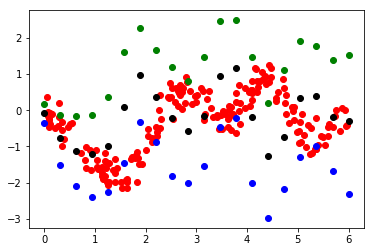

In [24]:
plt.plot(X,Y, 'ro')
plt.plot(X_u_noisy, eta_perc_25, 'bo')
plt.plot(X_u_noisy, eta_perc_975, 'go')
plt.plot(X_u_noisy, eta_mean, 'ko')

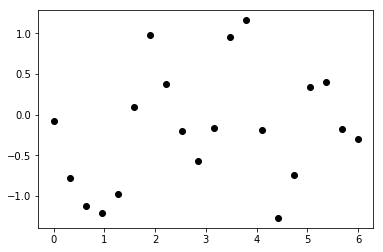

In [25]:
plt.plot(X_u_noisy, eta_mean, 'ko')

In [27]:

class ProcessStanSamples(object):
    
    def _params_samples(samples):
        keys = list(samples.keys())
        return keys
    
    def plot_histograms(samples):
        sigma_samples = samples['sigma']
        rho_samples = samples['rho']
        alpha_samples = samples['alpha']
        if 'f' in self._params_samples(samples):
            f_samples = samples['f']
        
        if 'u' in self._params_samples(samples):
            u_samples = samples['u']
        
        
        f, axs = plt.subplots(2,2, sharey=True)
        axs[0,0].hist(sigma_samples)
        axs[0,0].set_title('Plotting samples for sigma')
        axs[0,0].legend(['Noise variance'])
        axs[0,1].hist(rho_samples)
        axs[0,1].set_title('Plotting samples for lengthscale')
        axs[0,1].legend(['lengthscale'])
        axs[1,0].hist(alpha_samples)
#         axs[1,0].set_title('Plotting samples for signalvariance')
        axs[1,0].legend(['signal var'])
    
    
        
    

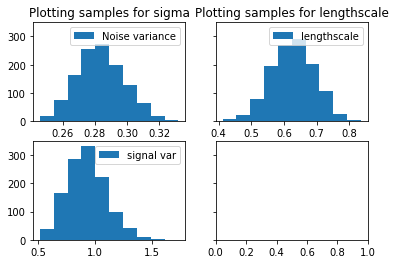

In [28]:
f, axs = plt.subplots(2,2, sharey=True)
axs[0,0].hist(sigma_samples)
axs[0,0].set_title('Plotting samples for sigma')
axs[0,0].legend(['Noise variance'])
axs[0,1].hist(rho_samples)
axs[0,1].set_title('Plotting samples for lengthscale')
axs[0,1].legend(['lengthscale'])
axs[1,0].hist(alpha_samples)
# axs[1,0].set_title('Plotting samples for signalvariance')
axs[1,0].legend(['signal var'])

In [29]:
eta_samples = samples['eta']

In [30]:
N_star = 30
X_star = np.linspace(-1, 7.0, N_star)[:, None]

In [31]:
print(alpha_samples.shape)

(1200,)


In [32]:
def kernel_rbf(alpha, rho, Xi, Xj=None):
    if Xj is None:
        Xj = Xi
    
    N1,D1 = Xi.shape[0],1
    N2,D2 = Xj.shape[0],1
    
    diff = Xi.reshape(N1,1,D1) - Xj.reshape(1,N2,D2)
    K = (alpha**2)*np.exp(-0.5*np.sum(np.square(diff),-1)/(rho)**2)
    return K
    

In [33]:
Kuu = kernel_rbf(alpha=1.0, rho =0.8, Xi=X_u_noisy)

In [34]:
K_star_u = kernel_rbf(alpha=1.0, rho =0.8, Xi=X_star, Xj=X_u_noisy)

####  Utility function to generate predictive distribution:

$p(f^*|y) = \int \int p(f^*|u) q(u, \theta) du d\theta$

We will obtain the above expression using MCMC samples. The stan code above samples from the optimal variational distribution $q(u,\theta)$. 

In [35]:
# function to generate mean and covariance matrics ..

def generate_preds(alpha, rho, v, Xi, Xj):
    Kuu = kernel_rbf(alpha, rho, Xi=X_u_noisy)
    K_star_u = kernel_rbf(alpha, rho, Xi=X_star, Xj=X_u_noisy)
    K_star_star = kernel_rbf(alpha, rho, Xi=X_star)
    
    R = np.linalg.cholesky(Kuu)
    A = np.linalg.solve(R, np.transpose(K_star_u))
#     print(A.shape)
    A_T = np.transpose(A)
    f_star_mean = np.dot(A_T, v)
    Q_star_star = np.dot(A_T, A)
    
    S = K_star_star - Q_star_star
    return f_star_mean, S



####   Plot for predictive distribution for Snelson dataset using samples obtained from optimal variational distribution : q(v, $\theta$)

In [39]:
N_full = 400

In [65]:
f_sum = np.zeros(N_star)
f_sum2 = np.zeros(N_star)
S_sum = np.zeros((N_star,N_star))
S_diag = np.zeros(N_star)
for i in range(N_samples):
    f_star_mean, S = generate_preds(alpha=alpha_samples[i], rho =rho_samples[i], v =eta_samples[i,:],  Xi=X_star, Xj=X_u_noisy)
    f_sum = f_sum + f_star_mean
    f_sum2 = f_sum2 + f_star_mean**2
    S_sum = S_sum + S
    S_diag = np.diag(S)
    

In [66]:
cov_fin = S_diag/N_samples + f_sum2/N_samples - (f_sum/N_samples)**2

In [41]:
f_fin = f_sum / N_samples
S_sum = S_sum / N_samples

In [69]:
print(f_fin)

[ 0.0673187   0.09960378  0.10142007  0.03028388 -0.15684484 -0.47931047
 -0.90147671 -1.33825087 -1.69138577 -1.82696673 -1.57672225 -0.91646733
 -0.1113866   0.44208678  0.51565401  0.19790953 -0.15282372 -0.13901383
  0.31484931  0.81009793  0.81337086  0.21298909 -0.53023138 -0.84889022
 -0.62967866 -0.23425458 -0.02523639 -0.03873735 -0.11217128 -0.13345584]


In [71]:
print(np.diag(S_sum))

[5.45443379e+02 2.33648459e+02 4.60115180e+01 1.61759781e+00
 2.95628835e-02 2.29203313e-03 1.25633084e-04 3.26046378e-05
 2.39690220e-04 4.47984387e-04 5.50863774e-04 5.08979021e-04
 3.48386170e-04 1.51249732e-04 1.84145496e-05 1.84145496e-05
 1.51249732e-04 3.48386170e-04 5.08979021e-04 5.50863774e-04
 4.47984387e-04 2.39690220e-04 3.26046378e-05 1.25633084e-04
 2.29203313e-03 2.95628835e-02 1.61759781e+00 4.60115180e+01
 2.33648459e+02 5.45443379e+02]


In [1]:
print(cov_fin)

NameError: name 'cov_fin' is not defined

In [74]:
print(cov_fin[10])
print(np.diag(S_sum)[10])

0.004741459470924081
0.000550863773712662


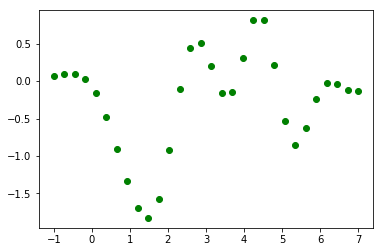

In [42]:
plt.plot(X_star, f_fin, 'go')

In [43]:
a = np.random.multivariate_normal(f_fin, S_sum, 6)

In [77]:
a2 = np.random.multivariate_normal(f_fin, np.diag(cov_fin), 8)

In [44]:
print(a.shape)

(6, 30)


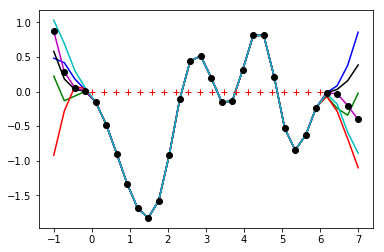

In [80]:
plt.plot(X_star, a[0], 'g-')
plt.plot(X_star, a[1], 'b-')
plt.plot(X_star, a[2], 'r-')
plt.plot(X_star, a[3], 'k-')
plt.plot(X_star, a[4], 'm-')
plt.plot(X_star, a[5], 'c-')
plt.plot(X_star, a[4], 'ko')
# plt.plot(X, Y, 'mo')
plt.plot(X_u_noisy, np.zeros(X_u_noisy.shape[0]), 'r+')

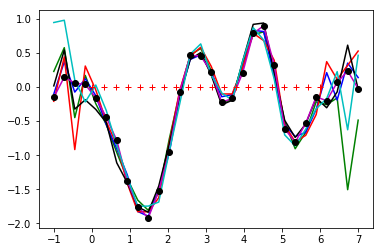

In [82]:
plt.plot(X_star, a2[0], 'g-')
plt.plot(X_star, a2[1], 'b-')
plt.plot(X_star, a2[2], 'r-')
plt.plot(X_star, a2[3], 'k-')
plt.plot(X_star, a2[4], 'm-')
plt.plot(X_star, a2[5], 'c-')
plt.plot(X_star, a2[4], 'ko')
# plt.plot(X, Y, 'mo')
plt.plot(X_u_noisy, np.zeros(X_u_noisy.shape[0]), 'r+')

#####  Generate plot for u 

In [48]:
def generate_u(alpha, rho, v, Xi):
    Kuu = kernel_rbf(alpha, rho, Xi=Xi)
    R = np.linalg.cholesky(Kuu)

    u_mean = np.dot(R, v)
    return u_mean

In [49]:
u_sum = np.zeros(M)
# S_sum = np.zeros((N,N))
for i in range(N_samples):
    u_mean = generate_u(alpha=alpha_samples[i], rho =rho_samples[i], v =eta_samples[i,:], Xi = X_u_noisy)
    u_sum = u_sum + u_mean

In [50]:
u_fin = u_sum / N_samples

Plot of inducing inputs and inducing outputs(u)

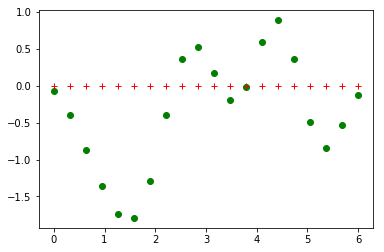

In [53]:
plt.plot(X_u_noisy, u_fin, 'go')
plt.plot(X_u_noisy, np.zeros(X_u_noisy.shape[0]), 'r+')